# ML in Cybersecurity: Project III

## Team
  * **Team name**:  MMM
  * **Members**:  Maria Sargsyan (2576831,msargsyan@mpi-inf.mpg.de), Muneeb Aadil (2581794, maadil@mpi-inf.mpg.de), Muhammad Yaseen (2577833, myaseen@mpi-inf.mpg.de).
  * **Tutor**: *???*


## Logistics
  * **Due date**: 12th December 2019, 13:59:59 
  * Email the completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland 
  * Complete this in the previously established **teams of 3**
  * Feel free to use the course [mailing list](https://lists.cispa.saarland/listinfo/mlcysec_ws1920_stud) to discuss.
  
## Timeline
  * 28-Nov-2019: Project 3 hand-out
  * **12-Dec-2019** (13:59:59): Email completed notebook to mlcysec_ws1920_staff@lists.cispa.saarland

  * 19-Dec-2019: Project 3 discussion and summary
  
  
## About this Project
In this project, we dive into the vulnerabilities of machine learning models and the difficulties of defending against them. To this end, we require you to implement an evasion attack (craft adversarial examples) yourselves, and defend your own model.   


## A Note on Grading
The total number of points in this project is 100. We further provide the number of points achievable with each excercise. You should take particular care to document and visualize your results, though.


 
## Filling-in the Notebook
You'll be submitting this very notebook that is filled-in with (all!) your code and analysis. Make sure you submit one that has been previously executed in-order. (So that results/graphs are already visible upon opening it). 

The notebook you submit **should compile** (or should be self-contained and sufficiently commented). Check tutorial 1 on how to set up the Python3 environment.

It is extremely important that you **do not** re-order the existing sections. Apart from that, the code blocks that you need to fill-in are given by:
```
#
#
# ------- Your Code -------
#
#
```
Feel free to break this into multiple-cells. It's even better if you interleave explanations and code-blocks so that the entire notebook forms a readable "story".


## Code of Honor
We encourage discussing ideas and concepts with other students to help you learn and better understand the course content. However, the work you submit and present **must be original** and demonstrate your effort in solving the presented problems. **We will not tolerate** blatantly using existing solutions (such as from the internet), improper collaboration (e.g., sharing code or experimental data between groups) and plagiarism. If the honor code is not met, no points will be awarded.

 
 ## Versions
  * v1.0: Initial notebook
  * v1.1: Clarifications at 1.1.2, 1.2.2, 2.1
 
  ---

In [1]:
import time 
 
import numpy as np 
import matplotlib.pyplot as plt 

import json 
import time 
import pickle 
import sys 
import csv 
import os 
import os.path as osp 
import shutil 

import pandas as pd

from IPython.display import display, HTML
 
%matplotlib inline 
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots 
plt.rcParams['image.interpolation'] = 'nearest' 
plt.rcParams['image.cmap'] = 'gray' 
 
# for auto-reloading external modules 
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython 
%load_ext autoreload
%autoreload 2

# Some suggestions of our libraries that might be helpful for this project
from collections import Counter          # an even easier way to count
from multiprocessing import Pool         # for multiprocessing
from tqdm import tqdm                    # fancy progress bars

# Load other libraries here.
# Keep it minimal! We should be easily able to reproduce your code.
# We only support sklearn and pytorch.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision

# We preload pytorch as an example
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset


# Debugging
import pdb

In [2]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

#### Helpers

In case you choose to have some methods you plan to reuse during the notebook, define them here. This will avoid clutter and keep rest of the notebook succinct.

In [3]:
def identity_func(foo):
    return foo

def data_to_arrays(data):
    out1 = []
    out2 = []
    for d in data:
        x, y = d
        out1.append(x)
        out2.append(y)
    out1 = torch.cat(out1, dim=0)
    out2 = torch.IntTensor(out2)
    return out1, out2

class IncorrectPrediction:
    def __init__(self, true_label, predicted_label, image, prob_dist):
        self.true_label = true_label
        self.predicted_label = predicted_label
        self.image = image
        self.prob_dist = prob_dist
        

class AdversarialExample:
    
    def __init__(self, true_label, adv_label, 
                 true_image, adv_image, gen_method, 
                 true_score, adv_score):
        
        self.true_label = true_label
        self.adv_label  = adv_label
        self.true_image = true_image
        self.adv_image  = adv_image
        self.gen_method = gen_method
        self.true_score = np.exp(true_score)/np.sum(np.exp(true_score))
        self.adv_score  = np.exp(adv_score)/np.sum(np.exp(adv_score))
        
        
def get_accuracy_from_predictions(actual, predictions, verbose=False):

    assert actual.size() == predictions.size()
    incorrect = torch.sum(predictions != actual).item()
    total = float(actual.size()[0])
    acc = 1 - (incorrect / total)
    if verbose: 
      print('{0} predictions not correct from a total of {1}'.format(incorrect, total))
      print('Accuracy: {0}%'.format(acc*100))
    
    return acc

# 1. Attacking an ML-model

In this section, we implement an attack ourselves. We then leverage the Foolbox library to craft adversarial examples. First, however, you need a model you can attack. Feel free to choose the DNN/ConvNN from project 1.

Hint: you might want to save the trained model to save time later.

### 1.1.1: Setting up the model (5 Points)

Re-use the model from project 1 here and train it until it achieves reasonable accuracy (>92%).

#### 1.1.1.1: Loading MNIST Data

Load and process MNIST data

In [4]:
# Loading MNIST data
BATCH_SIZE = 4
VALIDATION_FRACTION = 0.1
EPOCHS = 2
CLASSES = [str(i) for i in range(0,10)]

tsfms = transforms.Compose([
    transforms.ToTensor(),  # data loader returns a PIL image, we need to transform it to a Tensor object
])

# train and test datasets, transformed to a tensor
mnist_train_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=True, transform=tsfms)
mnist_val_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=True, transform=tsfms)
mnist_test_data = torchvision.datasets.MNIST(root="./mnist-data/", download=True, train=False, transform=tsfms)

# we need to create a disjoint validation set from within the training set
# following the approach taken in this link
# https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb

num_training = len(mnist_train_data)
all_indices = list(range(num_training)) # this gives us indices over the whole training set
split = int(np.floor( VALIDATION_FRACTION * num_training))
# split indices into disjoint sets
train_indices, val_indices = all_indices[split:], all_indices[:split]

# now we have the indices for train and val sets, we create a pytorch 
# custom sampler over both datasets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# represents a data loader, takes care of random batching and indexing etc.
mnist_train_data_loader = torch.utils.data.DataLoader(mnist_train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
mnist_val_data_loader   = torch.utils.data.DataLoader(mnist_val_data, batch_size=BATCH_SIZE, sampler=val_sampler)
mnist_test_data_loader  = torch.utils.data.DataLoader(mnist_test_data, batch_size=1, shuffle=False)

# we need this to construct adversarial examples easily.
# if we directly use train_data_loader, it gives shuffled data and in 
# batches of 4, we OTOH want unshuffled and 1 example.
mnist_adv_data_loader = torch.utils.data.DataLoader(mnist_train_data, batch_size=1, shuffle=False)


#### 1.1.1.2: Defining the Model

Define the CNN Model

In [5]:
# Model represented as class

class CNNModel(nn.Module):

    def __init__(self):
    
        super(CNNModel, self).__init__()

        ## formula to make sure params work out
        ## W_out = (W_in - F)/S + 1
        ## from http://cs231n.github.io/convolutional-networks/

        ## we will have 2 conv layers

        # in_channel is 1 bcz MNIST is a BW dataset
        # from 1 input, we create 6 output feature maps, using 5x5 kernels
        # input is 28x28, output will be 24x24
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)

        # max pool over the 2x2 region.
        # input is 24x24, output will be 12x12 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # after max pool, out spatial dim is reduced, but num channels coming from 
        # prev conv1 is still 6. We create 16 feature maps, again using 5x5 kernels
        # input is 12x12, output will be 8x8
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        # max pool over the 2x2 region. 
        # input is 8x8, output will be 4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        ## followed by 2 FC layers, y = Wx + b
        # we take features computer after the pool2 step.
        # we have 16 maps, each of size 4x4. We will flatten them
        self.fc1 = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)

        ## and a last FC layer for predictions
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    # we define the fwd pass, backward pass is automatically defined 
    # by PyTorch thru lineage

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        # flatten
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        #x = F.tanh(self.fc1(x))
        #x = F.tanh(self.fc2(x))
        x = self.fc3(x)

        return x

In [6]:
# Function to test the model on a give (sub)set.

def test_model(cnn_model, is_test_set=False, verbose=False):

    class_preds = []
    ground_truth = []
    incorrect_predictions = []
    TEST = is_test_set


    with torch.no_grad():
        for data in mnist_test_data_loader if TEST else mnist_val_data_loader:
            images, labels = data

            # get (unnormalized) predictions
            predictions = cnn_model(images)
            # normalize to get probability distribution
            batch_class_probabilities = [F.softmax(el, dim=0) for el in predictions]
            # get index of max value which corresponds to the predicted label
            # we discard actual values because they are of no use as we use 
            # probability dist
            _, predicted_labels = torch.max(predictions, 1)

            # we save some of the incorrect predictions to view them later for 
            # insights and reasoning
            for i,(t,p) in enumerate(zip(labels.tolist(),predicted_labels.tolist())):
                if t != p:
                    incorrect_predictions.append(IncorrectPrediction(t,p,images[i],batch_class_probabilities[i]))

            ground_truth.append(labels)
            #class_probs.append(batch_class_probabilities)
            class_preds.append(predicted_labels)

    # concat predictions from all batches to get a single vector
    test_preds = torch.cat(class_preds)
    # actual labels
    ground_truth = torch.cat(ground_truth)
    # calculate accuracy in percentage given predictions and ground truth
    accuracy = get_accuracy_from_predictions(ground_truth, test_preds, verbose=verbose)

    return accuracy, incorrect_predictions

#### 1.1.1.3: Defining the Loss function, Optimization, and Training Loop

In [8]:
# initialize an instance of CNN model
cnn_model = CNNModel()

# automatically takes care of one-hot encoding the labels 
# https://pytorch.org/docs/stable/nn.html#crossentropyloss
loss_fn = nn.CrossEntropyLoss() 
optimizer = optim.SGD(cnn_model.parameters(), lr=0.001, momentum=0.9)

running_loss = 0.0
val_acc_history = []
loss_history = []

best_model = None
best_val_acc = None
# the training loop
for epoch in range(EPOCHS):

    print("Epoch [{} / {}]".format(epoch+1, EPOCHS))
    for i, data in tqdm(enumerate(mnist_train_data_loader, 0)):

        inputs, labels = data
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 1000 == 999:
            loss_per_1k = running_loss / 1000.0
            loss_history.append(loss_per_1k)
            
            val_acc, _ = test_model(cnn_model, is_test_set=False)
            val_acc_history.append(val_acc)
            
            print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))
            
            running_loss = 0.0

print("Finished training")

9it [00:00, 78.75it/s]

Epoch [1 / 2]


1021it [00:08, 24.52it/s]

Loss: 2.294882250070572 	 Validation Accuracy: 25.4%


2026it [00:19, 16.06it/s] 

Loss: 1.5563014516271652 	 Validation Accuracy: 81.96666666666667%


3014it [00:32, 11.55it/s] 

Loss: 0.42080974123906345 	 Validation Accuracy: 91.96666666666667%


4023it [00:42, 22.96it/s] 

Loss: 0.26908470528037287 	 Validation Accuracy: 93.63333333333334%


5019it [00:52, 19.40it/s] 

Loss: 0.21000112865847767 	 Validation Accuracy: 95.39999999999999%


6020it [01:02, 25.43it/s] 

Loss: 0.15966528247332462 	 Validation Accuracy: 96.03333333333333%


7013it [01:12, 16.85it/s] 

Loss: 0.17007265138000366 	 Validation Accuracy: 94.71666666666667%


8007it [01:19, 36.15it/s] 

Loss: 0.1499237997391465 	 Validation Accuracy: 96.0%


9013it [01:28, 26.35it/s] 

Loss: 0.14298264545518033 	 Validation Accuracy: 95.89999999999999%


10026it [01:37, 23.96it/s]

Loss: 0.1366205158978919 	 Validation Accuracy: 95.68333333333334%


11024it [01:47, 26.58it/s] 

Loss: 0.11142310378432739 	 Validation Accuracy: 97.13333333333334%


12025it [01:56, 29.00it/s] 

Loss: 0.11915542259835638 	 Validation Accuracy: 97.23333333333333%


13024it [02:10, 15.71it/s] 

Loss: 0.09695178625350309 	 Validation Accuracy: 97.43333333333334%


13500it [02:13, 101.23it/s]
25it [00:00, 249.01it/s]

Epoch [2 / 2]


1036it [00:07, 19.01it/s]

Loss: 0.14563944652492136 	 Validation Accuracy: 96.65%


2015it [00:15, 37.61it/s] 

Loss: 0.08006627682904946 	 Validation Accuracy: 97.5%


3012it [00:26, 13.14it/s] 

Loss: 0.0832274521874424 	 Validation Accuracy: 97.15%


4024it [00:37, 19.94it/s] 

Loss: 0.0844800882551899 	 Validation Accuracy: 97.85000000000001%


5002it [00:50, 11.37it/s] 

Loss: 0.08467935696671157 	 Validation Accuracy: 96.33333333333334%


6032it [01:01, 28.82it/s] 

Loss: 0.07876643193680957 	 Validation Accuracy: 97.66666666666667%


7020it [01:09, 28.21it/s] 

Loss: 0.06785180580786891 	 Validation Accuracy: 97.86666666666667%


8018it [01:19, 25.90it/s] 

Loss: 0.07035395660849736 	 Validation Accuracy: 97.66666666666667%


9001it [01:28, 18.94it/s] 

Loss: 0.07824270795823213 	 Validation Accuracy: 97.11666666666666%


10033it [01:39, 33.54it/s]

Loss: 0.08024027081369287 	 Validation Accuracy: 97.65%


10627it [01:43, 188.31it/s]

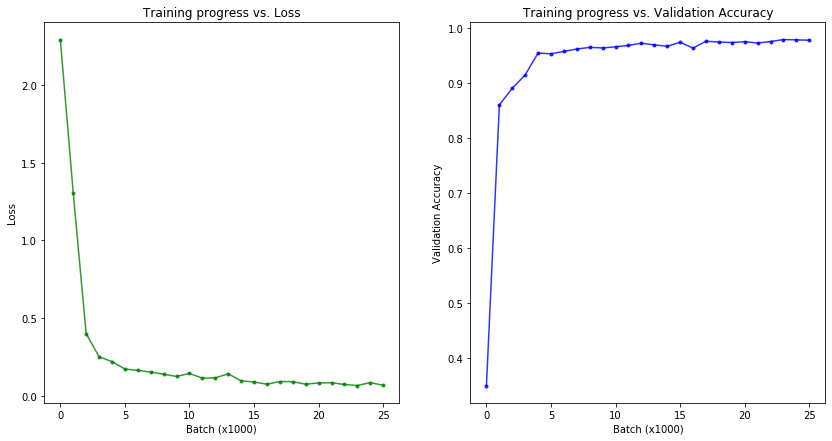

<Figure size 432x288 with 0 Axes>

In [14]:
# Visualize trainset performance

# plot loss curve per 1000 batches (per 4000 examples if BS = 4)
# Note: we didn't plot it against num_epochs because we didn't run many epochs as network 
# converges after 1 or 2. We thought it would be more interesting to see trends b/w batches.
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[0].plot(range(len(loss_history)), loss_history,  
         color='g', alpha=0.8, marker='.')
ax[0].set( 
    xlabel='Batch (x1000)', 
    ylabel='Loss', 
    title='Training progress vs. Loss')


# plot val acc per 1000 batches (per 4000 examples if BS = 4)
ax[1].plot(range(len(val_acc_history)), val_acc_history,  
         color='b', alpha=0.8, marker='.')
ax[1].set( 
    xlabel='Batch (x1000)', 
    ylabel='Validation Accuracy', 
    title='Training progress vs. Validation Accuracy')
plt.show()
plt.tight_layout()

#### 1.1.1.4: Evaluation

Before attacking the model, we need to make sure that it achieves >95% accuracy on test set.


In [16]:
accuracy, incorrect_predictions = test_model(cnn_model, is_test_set=True, verbose=False)
print('Accuracy on unseen test data is {0}%'.format(accuracy*100))

Accuracy on unseen test data is 97.94%


In [19]:
# save the trained model.
MODEL_SAVE_PATH = './victim-model.pth'
torch.save(cnn_model.cpu().state_dict(), MODEL_SAVE_PATH)

### 1.1.2: Implementing an attack (15 Points)

We now want you to attack the model trained in the previous step. Please implement the FGSM attack mentioned in the lecture. 

In [6]:
def FGSM(model, Xtrue, Ytrue, criterion, epsilon=0.01, min_val=0, max_val=1):
    """
    Implements the one step FGSM attack.
    """
    # we use this for calculating gradients for image,
    Xtrue.requires_grad = True
    # which is turned off by default.
    
    Ypred = model(Xtrue)
    _, pred_classes_before = torch.max(Ypred, dim=1)
    pred_classes_before = pred_classes_before.data

    # TODO: generalize min_val and max_val variables.
    loss = criterion(Ypred, Ytrue)
    
    # calculate gradients
    model.zero_grad()
    loss.backward()
    
    # pdb.set_trace()
    
    with torch.no_grad():
        grad_sign = Xtrue.grad.data.sign()
        Xperturbed = Xtrue.data + (epsilon * grad_sign)
        Xperturbed = torch.clamp(Xperturbed, min=0, max=1)
        
        Ypred_ = model(Xperturbed)
        _, pred_classes_after = torch.max(Ypred_, dim=1)
        pred_classes_after = pred_classes_after.data
        
    return Xperturbed, pred_classes_before, pred_classes_after

### 1.1.3: adversarial sample set (5 Points)

Please additionally generate a dataset containing at least 1,000 adversarial examples using FGSM.

In [7]:
def create_dataset(model, loader, criterion, device, epsilon=0.2, max_limit=2000):
    curr_adv_samples = 0.0
    total = 0.0
    advXtrue, advXnew, advYtrue, advYnew = [], [], [], []
    for (Xtest, Ytest) in tqdm(loader):
        Xtest = Xtest.to(device)
        Ytest = Ytest.to(device)
        Yperturbed, preds_before, preds_after = FGSM(model ,Xtest, Ytest,
                                                     criterion, epsilon=epsilon)
        if (preds_before == Ytest) and (preds_before != preds_after):
            advXtrue.append(Xtest.data)
            advXnew.append(Yperturbed)
            advYtrue.append(preds_before)
            advYnew.append(preds_after)
            
            curr_adv_samples += 1

        if (max_limit > 0) and (curr_adv_samples == max_limit):
            break
        total += 1

    advXtrue = torch.cat(advXtrue, dim=0)
    advXnew = torch.cat(advXnew, dim=0)
    advYtrue = torch.cat(advYtrue, dim=0)
    advYnew = torch.cat(advYnew, dim=0)
    
    return (advXtrue, advXnew, advYtrue, advYnew, curr_adv_samples / total)

In [8]:
# load the trained model
MODEL_LOAD_PATH = './victim-model.pth'
victim_model = CNNModel().to(device)
victim_model.load_state_dict(torch.load(MODEL_LOAD_PATH))
victim_model.eval()

criterion = torch.nn.CrossEntropyLoss().to(device)

# create dataset
adv_dataset = create_dataset(victim_model, mnist_test_data_loader, criterion, device, epsilon=.3, max_limit=-1)

100%|██████████| 10000/10000 [01:29<00:00, 112.03it/s]


### 1.1.3: Visualizing the results (5 Points)

Please chose one sample for each class (for example the first when iterating the test data) and plot the (ten) adversarial examples as well as the predicted label (before and after the attack)

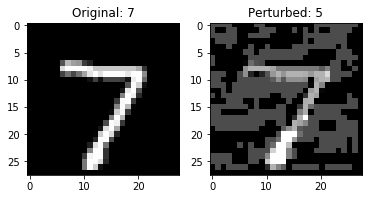

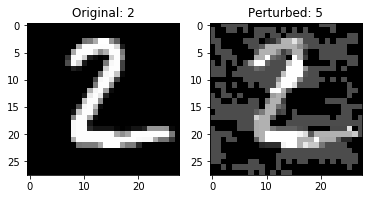

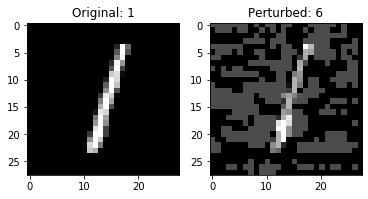

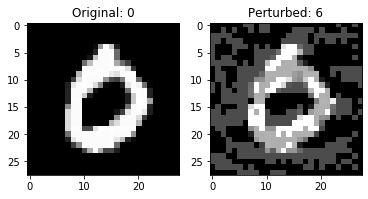

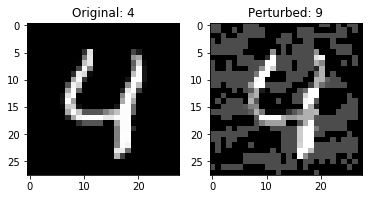

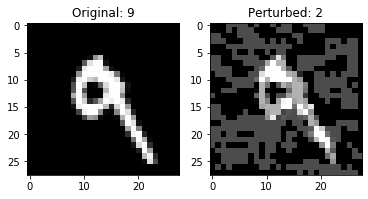

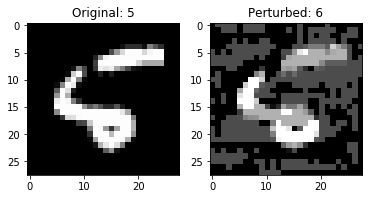

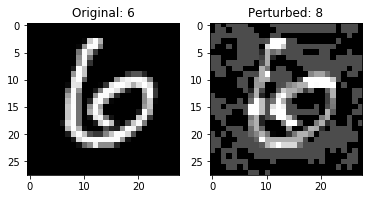

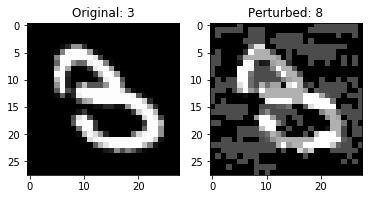

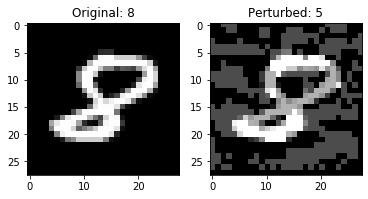

In [12]:
classes_done = [False] * 10 # number of classes.
advXtrue, advXnew, advYtrue, advYnew, _ = adv_dataset

# save for future
#with open('adv_dataset.pkl','wb'):
#    pickle.dump(adv_dataset)

for i in range(len(advXtrue)):
    # print("i: {}".format(i))
    if not classes_done[advYtrue[i]]:
        # pdb.set_trace()
        classes_done[int(advYtrue[i])] = True
        fig, ax = plt.subplots(ncols=2)
        
        ax[0].imshow(advXtrue[i, 0])
        ax[0].set_title("Original: {}".format(int(advYtrue[i])))
        
        ax[1].imshow(advXnew[i, 0])
        ax[1].set_title("Perturbed: {}".format(int(advYnew[i])))
        
    if sum(classes_done) == 10:
        break

### 1.2.1: Using libraries for attacks (10 Points)
As the field of evasion attacks (in particular for DNN) is very active research field, several libraries have been published that contain attacks. We will work here with the Foolbox (https://github.com/bethgelab/foolbox) library. Please implement two other (recent, advanced) attacks of your choice using this library. 

In [79]:
import foolbox
import numpy as np
import torchvision.models as models

# advXtrue, advXnew, advYtrue, advYnew

def attack_model(victim_model, max_adv_examples, attack_name, **attack_params):
    
    """
    
    """
    print("attacking via " + attack_name)
    supported_attacks = ['spatial',  # Spatial Attack
                         'gaussblur', # Boundary Attack
                        ]
    assert attack_name in supported_attacks, "Attack Not supported"
    
    fmodel = foolbox.models.PyTorchModel(victim_model, bounds=(0, 1), 
                                     num_classes=10)
    adversarial_examples = []
      
    # initialize attack
    attack = None
    
    if attack_name == 'spatial':
        attack = foolbox.attacks.SpatialAttack(fmodel)
    if attack_name == 'gaussblur':
        attack = foolbox.attacks.GaussianBlurAttack(fmodel)
        
    #for i, data in tqdm(enumerate(mnist_adv_data_loader, 0)):
    for i, data in tqdm(enumerate(zip(advXtrue,advYtrue), 0)):

        inputs, labels = data
        
        labels = torch.unsqueeze(labels, dim=0) # foolbox needs a batch dim
        inputs = torch.unsqueeze(inputs, dim=0)
        
        adversarials = attack(inputs.numpy(), labels.numpy())
        
        adversarial_examples.append(
            AdversarialExample(
                true_label  = labels.item(),
                adv_label   = torch.argmax(
                                 victim_model(
                                    torch.unsqueeze(torch.Tensor(adversarials[0]),1)
                                 )
                              ).detach().numpy(),        # from tensor to numpy
                true_image  = inputs[0].squeeze(),       # get rid of batch dimension
                adv_image   = adversarials[0].squeeze(), # get rid of batch dimension
                gen_method  = attack_name,
                true_score  = victim_model(torch.unsqueeze(inputs[0],1)).detach().numpy()[0],
                adv_score   = victim_model(torch.unsqueeze(torch.Tensor(adversarials[0]),1)).detach().numpy()[0],
            )
        )
        
        if len(adversarial_examples) >= max_adv_examples:
            break
    
    return adversarial_examples

In [80]:
MODEL_SAVE_PATH = './victim-model.pth'
tried_attacks = ['spatial', 'gaussblur']
found_adversaries = {}

MAX_ADV = 10

# instantiate model
victim_model = CNNModel()
victim_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
victim_model.eval()

for atk in tried_attacks:
    print(atk)
    found_adversaries[atk] = attack_model(victim_model, max_adv_examples=MAX_ADV, 
                                        attack_name=atk, attack_params=None)


# put our adversarial dataset in the form we can later use in visualization
# advXtrue, advXnew, advYtrue, advYnew

found_adversaries['FSGM'] = []
tried_attacks.append('FSGM')

for i in range(0, MAX_ADV):
    
    found_adversaries['FSGM'].append(
                AdversarialExample(
                    true_label  = advYtrue[i],
                    adv_label   = torch.argmax(
                                     victim_model(
                                        torch.unsqueeze(torch.Tensor(advXtrue[i]),1)
                                     )
                                  ).detach().numpy(),        # from tensor to numpy
                    true_image  = advXtrue[i] ,       # get rid of batch dimension
                    adv_image   = np.squeeze(advXnew[i])  , # get rid of batch dimension
                    gen_method  = 'FSGM',
                    true_score  = victim_model(torch.unsqueeze(advXtrue[i],1)).detach().numpy()[0],
                    adv_score   = victim_model(torch.unsqueeze(torch.Tensor(advXnew[i]),1)).detach().numpy()[0],
                )
            )

0it [00:00, ?it/s]
0it [00:00, ?it/s]

spatial
attacking via spatial
gaussblur
attacking via gaussblur


8it [00:01,  6.15it/s]


### 1.2.2: Visualizing the results (20 Points)
As before, please plot the new adversarial examples. Compare all crafting techniques (FGSM, 2 methods from Foolbox).


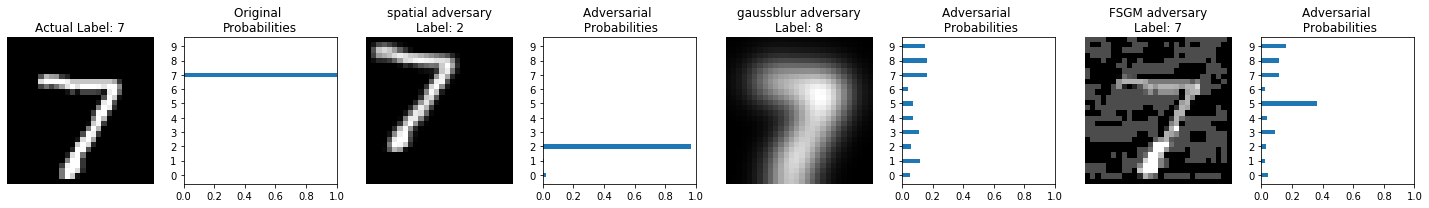

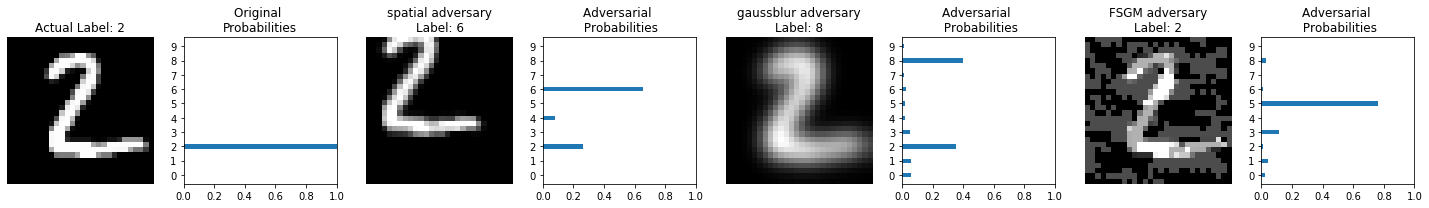

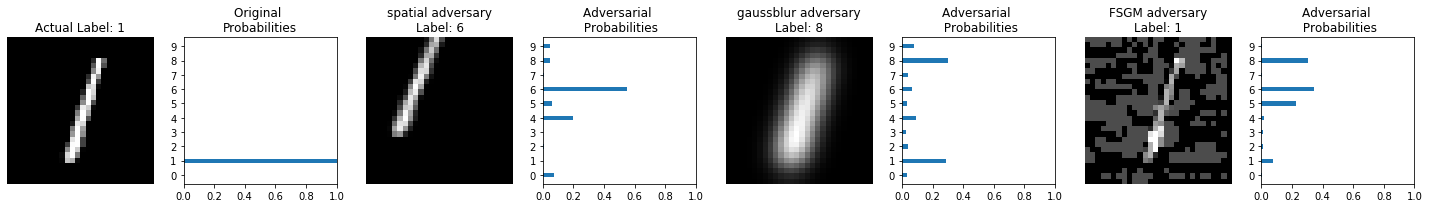

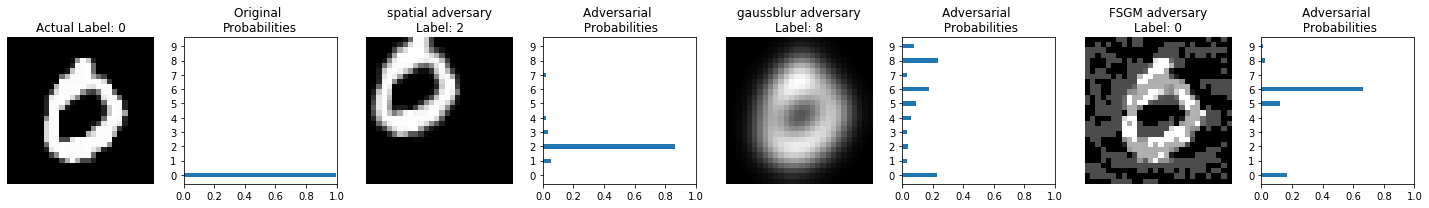

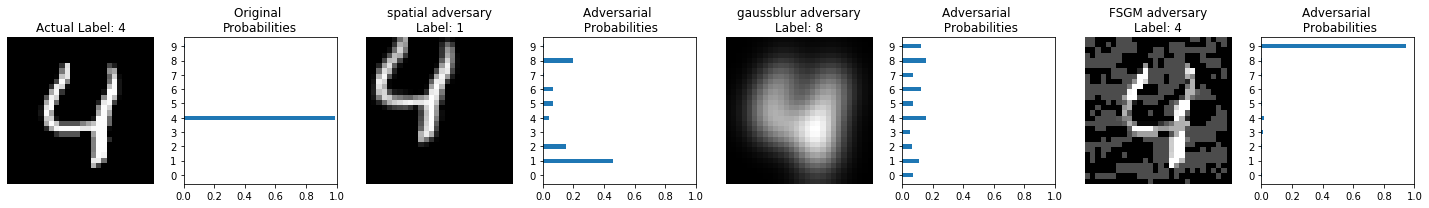

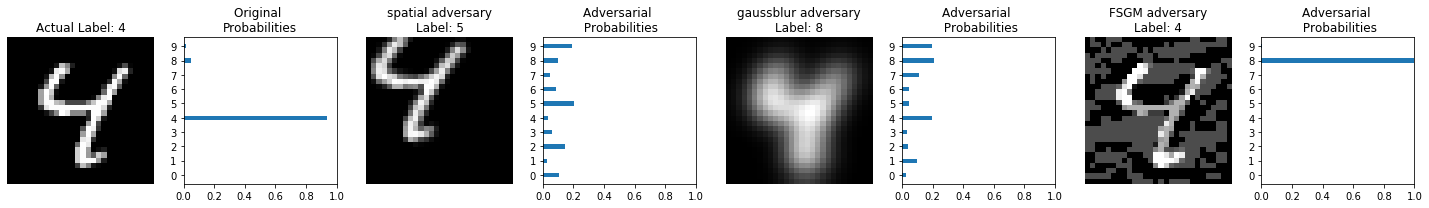

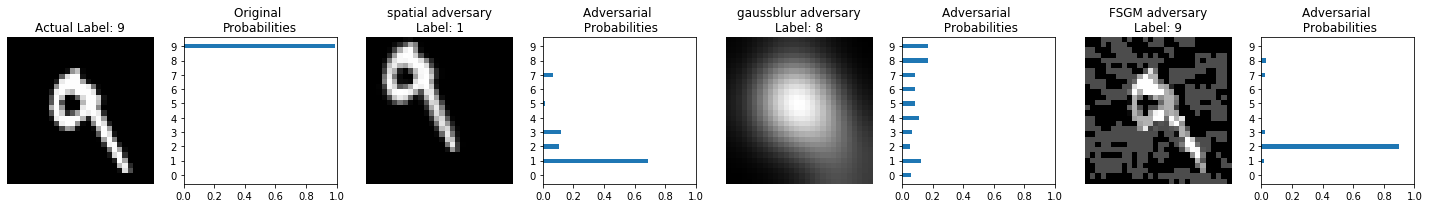

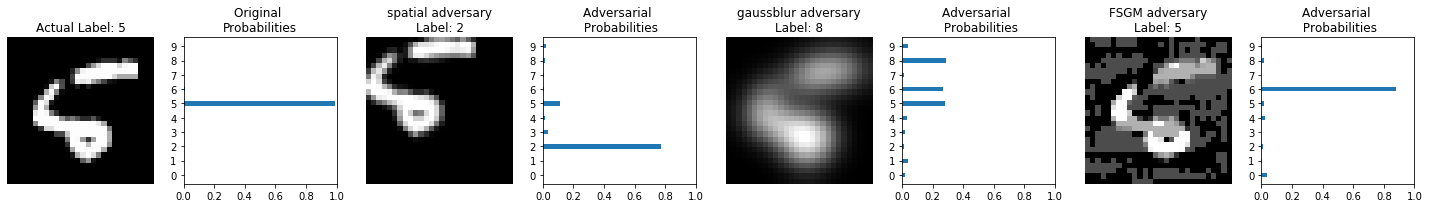

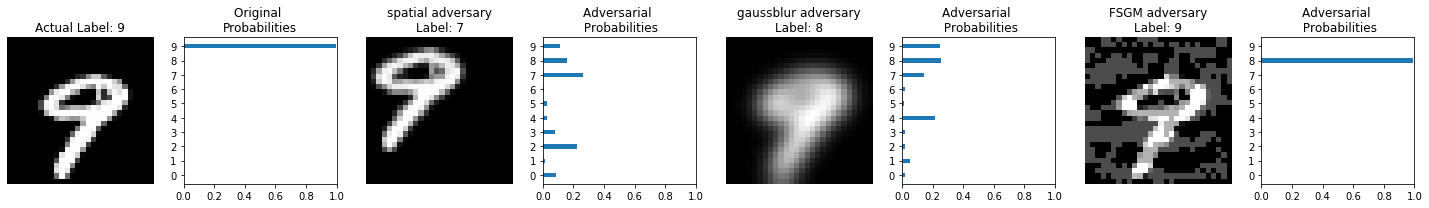

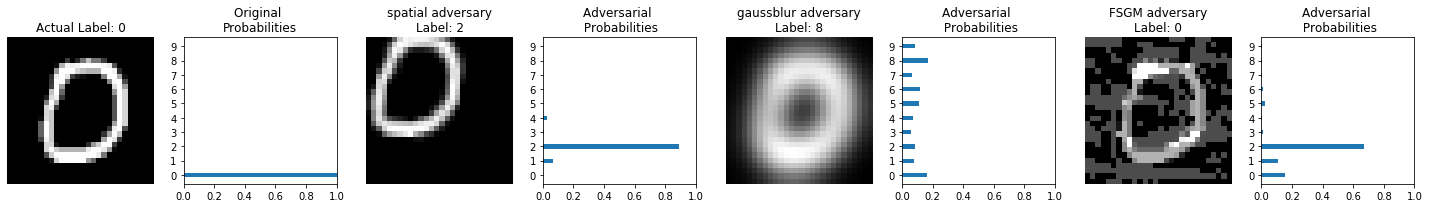

In [81]:
#print(found_adversaries)

for i in range(0,MAX_ADV):
    
    fig, ax = plt.subplots(ncols=2*len(tried_attacks) + 2, nrows = 1,figsize=(20,3))
    
    ax[0].imshow(found_adversaries[tried_attacks[0]][i].true_image,cmap='gray')
    ax[0].axis('off') # no need to show axes on images
    ax[0].set_title("Actual Label: {0}".format(found_adversaries[tried_attacks[0]][i].true_label))
    
    ax[1].barh(list(range(0,10)), found_adversaries[tried_attacks[0]][i].true_score, 0.3)
    ax[1].set_yticks(list(range(0,10))) # needed to show all class labels on y axis
    ax[1].set_xlim([0,1])
    ax[1].set_title("Original \nProbabilities")
    
    idx = 2
    
    for atk in tried_attacks:    
        
        ax[idx].imshow(found_adversaries[atk][i].adv_image,cmap='gray')
        ax[idx].axis('off')
        ax[idx].set_title(
            found_adversaries[atk][i].gen_method + " adversary\n" + 
            "Label: " + str(found_adversaries[atk][i].adv_label))
        
        ax[idx+1].barh(list(range(0,10)), found_adversaries[atk][i].adv_score, 0.3)
        ax[idx+1].set_yticks(list(range(0,10))) # needed to show all class labels on y axis
        ax[idx+1].set_xlim([0,1]) # need to do this, so bars are comparable visually.
        ax[idx+1].set_title("Adversarial \n Probabilities")
        
        idx = idx + 2
        
    plt.tight_layout()

Which differences do you observe when comparing different attack methods? Why?   
Please write a brief summary of your findings.   
* Does the attack always succeed (the model make wrong prediction on the adversarial sample)?

No. Before the current reported methods i.e. `Spatial` and `Gaussian` attacks, we also tried  `Single Pixel` attack and `Boundary` Attack. `Single Pixel` Attack didn't work at all for MNIST, perhaps expectedly, as it was described for colored images and the authors also didn't include a demo on MNIST. Boundary attack had a very high failure rate where foolbox couldn't find any adversary.

We found that `Spatial` and `Gaussian` attacks succeed almost always. Which is a bit surprising at least for `Spatial` attack as the visual quality of example is not affected at all and they still remain legitimate digits.

An *interesting* thing to note was that `Gaussian` attack results in the most "confused" model in the sense that predicted class probabilities as more spread out across classes. Compare that to `FSGM` and `Spatial` where model is mostly overconfident in its wrong prediction. This might be explained by the fact that Gaussian blurring causes the white pixels to get spread across the whole image domain causing spurious matches across many different learned convolution patterns.

* How different is the adversarial sample from the original image?

Compared to the original it is easy to see that `Spatial` adversary preserves the most "natural" looking examples. Whereas there is visible evidence of tampering in `FSGM`, and `Gaussian` methods which can easily be discarded by a prudent victim.

* How about the computation cost of each attack method?

Among the tried methods, `FSGM` is the most computationally demanding one, as it required backprop through the original model. On the other hand, `Spatial` and `Gaussian` attacks can be mounted very cheaply using simple matrix multiplication operations.

| Method    | Cost                 |
|-----------|:----------------------|
| FSGM      | Proportional to model size       | 
| Gaussian  | Simple convolution with a Gaussian kernele. O(N\*N\*w) w = kernel width| 
| Spatial   | Simple Multiplication with rotation matrix. O(N\*N\*N) N = image height/width| 


* Does the attack require white-box access to the model?

| Method    | White-box access                 |
|-----------|----------------------|
| FSGM      | Yes (calculating gradients)       | 
| Gaussian  | No | 
| Spatial   | No |


# 2. Defending an ML model

So far, we have focused on attacking an ML model. In this section, we want you to defend your model. As before concerning the attack, you can chose an example from the lecture, or experiment with any idea you have.

We do not require the defense to work perfectly - but what we want you to understand is why it works or why it does not work.

### 2.1: Implementing a defense of your choice (25 Points)
As stated before, feel free to implement a defense or mitigation of your choice. Evaluate the defense on adversarial examples. This entails at least the 1,000 examples crafted from FGSM.   
Also, you are encouraged (optional) to defend against the two other attack methods, i.e. you are free to increase this special test set (for example by >30 examples (>10 from your FGSM attack, >10 from both the two other attacks of the library)).

### 2.1.1. Defense Solution: Distillation [1]

[1] Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks

### 2.1.2. Trainer Function with Temperature

In [8]:
# Reference model (whose probabilities are to be distilled in second network)
def train_with_temperature(model, loss_fn, loader, optimizer, epochs, temperature, verbose=True, print_every=4000):
    running_loss = 0.0
    val_acc_history = []
    loss_history = []

    # the training loop
    for epoch in range(epochs):

        print("Epoch [{} / {}]".format(epoch+1, epochs))
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = model(inputs)
            outputs = outputs / temperature # softening in distillation
            
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % print_every == 0:
                loss_per_1k = running_loss / 1000.0
                loss_history.append(loss_per_1k)

                val_acc, _ = test_model(model, is_test_set=False)
                val_acc_history.append(val_acc)

                if verbose:
                    print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))

                running_loss = 0.0

    print("Finished training")
    
    return val_acc_history, loss_history, model

### 2.1.3. Distillation Function

In [9]:
def distil(teacher, student, loader, optimizer, epochs, temperature, alpha=.5, verbose=True, print_every=4000):
    running_loss = 0.0
    val_acc_history = []
    loss_history = []
    loss_fn = nn.MSELoss()

    for epoch in range(epochs):
        print("Epoch [{} / {}]".format(epoch+1, epochs))
        for i, data in tqdm(enumerate(loader)):
            inputs, labels = data
            optimizer.zero_grad()
            
            teacher_outputs = teacher(inputs)
            teacher_outputs = teacher_outputs / temperature
            
            student_outputs = student(inputs)
            student_outputs = student_outputs / temperature
            
            # pdb.set_trace()
            loss = loss_fn(student_outputs, teacher_outputs)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

            if i % print_every == 0:
                loss_per_1k = running_loss / 1000.0
                loss_history.append(loss_per_1k)

                val_acc, _ = test_model(student, is_test_set=False)
                val_acc_history.append(val_acc)

                if verbose:
                    print("Loss: {0} \t Validation Accuracy: {1}%".format(str(loss_per_1k), str(val_acc*100)))

                running_loss = 0.0
                
    print("Finished Distillation")
    return val_acc_history, loss_history, student

### 2.1.4. Apply Defensive Distillation

In [10]:
Ts = [1, 2, 5, 10, 20] # temperatures
Es = [1, 1, 1, 2, 5] # epochs for respective temperatures
for t, e in zip(Ts, Es): # training distillers on different temperatures
    print("Training Defensive Distillation with t={}".format(t))
    teacher_model = CNNModel().to(device)
    student_model = CNNModel().to(device)

    loss_fn_teacher = nn.CrossEntropyLoss().to(device)
    loss_fn_student = nn.Sequential()

    optimizer_teacher = optim.SGD(teacher_model.parameters(), lr=0.001, momentum=0.9)
    optimizer_student = optim.SGD(student_model.parameters(), lr=0.001, momentum=0.0)
    
    print("Training a teacher model...")
    _, _, teacher_model = train_with_temperature(
        teacher_model, loss_fn_teacher, mnist_train_data_loader, optimizer_teacher,
        epochs=e, temperature=t, print_every=4000
    )

    print("Distilling knowledge into student model...")
    _, _, student_model = distil(teacher_model, student_model, mnist_train_data_loader, optimizer_student,
           epochs=e, temperature=t, print_every=4000)

    # save the distilled (defensive) model
    MODEL_SAVE_PATH = 'defensive_model_t{}.pth'.format(t)
    torch.save(student_model.cpu().state_dict(), MODEL_SAVE_PATH)

0it [00:00, ?it/s]

Training Defensive Distillation with t=10
Training a teacher model...
Epoch [1 / 2]


22it [00:02,  1.41s/it]

Loss: 0.0023017029762268065 	 Validation Accuracy: 8.566666666666666%


4021it [00:22, 31.44it/s] 

Loss: 9.209805698871612 	 Validation Accuracy: 11.183333333333334%


8029it [00:43, 41.64it/s] 

Loss: 9.207428674459457 	 Validation Accuracy: 11.183333333333334%


12023it [01:05, 38.90it/s] 

Loss: 9.201364541292191 	 Validation Accuracy: 11.183333333333334%


13500it [01:12, 185.05it/s]
0it [00:00, ?it/s]

Epoch [2 / 2]


18it [00:02,  1.45s/it]

Loss: 3.4432639174461364 	 Validation Accuracy: 18.91666666666667%


4024it [00:25, 40.91it/s] 

Loss: 6.572565260808915 	 Validation Accuracy: 80.45%


8019it [00:46, 38.90it/s] 

Loss: 1.5632982072993182 	 Validation Accuracy: 91.18333333333332%


12032it [01:11, 31.70it/s] 

Loss: 0.8758144028639945 	 Validation Accuracy: 94.43333333333334%


13500it [01:19, 169.34it/s]
0it [00:00, ?it/s]

Finished training
Distilling knowledge into student model...
Epoch [1 / 2]


12it [00:02,  1.45s/it]

Loss: 0.01839233207702637 	 Validation Accuracy: 14.133333333333331%


4017it [00:36, 25.53it/s] 

Loss: 87.53541039180756 	 Validation Accuracy: 9.183333333333332%


8022it [01:09, 26.03it/s] 

Loss: 78.44331553077697 	 Validation Accuracy: 9.183333333333332%


12018it [01:40, 25.77it/s] 

Loss: 27.162129122555257 	 Validation Accuracy: 81.81666666666668%


13500it [01:53, 119.30it/s]
0it [00:00, ?it/s]

Epoch [2 / 2]


13it [00:02,  1.52s/it]

Loss: 3.0901004528701304 	 Validation Accuracy: 85.36666666666667%


4013it [00:40, 21.70it/s] 

Loss: 4.310588733315468 	 Validation Accuracy: 89.91666666666667%


8018it [01:14, 26.30it/s] 

Loss: 2.1428673663660884 	 Validation Accuracy: 91.78333333333333%


12016it [01:51, 22.32it/s] 

Loss: 1.3502766669392585 	 Validation Accuracy: 93.05%


13500it [02:02, 110.59it/s]
0it [00:00, ?it/s]

Finished Distillation
Training Defensive Distillation with t=20
Training a teacher model...
Epoch [1 / 5]


20it [00:02,  1.37s/it]

Loss: 0.0023019366264343264 	 Validation Accuracy: 10.850000000000005%


4036it [00:24, 33.63it/s] 

Loss: 9.210057958126068 	 Validation Accuracy: 10.850000000000005%


8027it [00:49, 33.16it/s] 

Loss: 9.209307656288146 	 Validation Accuracy: 10.850000000000005%


12019it [01:10, 32.73it/s] 

Loss: 9.207983483552933 	 Validation Accuracy: 10.850000000000005%


13500it [01:19, 170.62it/s]
0it [00:00, ?it/s]

Epoch [2 / 5]


20it [00:02,  1.51s/it]

Loss: 3.4523497910499574 	 Validation Accuracy: 11.033333333333328%


4038it [00:23, 39.42it/s] 

Loss: 9.20176077222824 	 Validation Accuracy: 26.449999999999996%


8033it [00:45, 33.08it/s] 

Loss: 9.121406735658645 	 Validation Accuracy: 34.416666666666664%


12021it [01:06, 32.08it/s] 

Loss: 3.6032976748272776 	 Validation Accuracy: 86.83333333333334%


13500it [01:14, 180.64it/s]
0it [00:00, ?it/s]

Epoch [3 / 5]


21it [00:02,  1.50s/it]

Loss: 0.6156945518276189 	 Validation Accuracy: 89.81666666666666%


4035it [00:24, 34.49it/s] 

Loss: 1.1501528802434913 	 Validation Accuracy: 93.51666666666667%


8021it [00:47, 33.42it/s] 

Loss: 0.8699899483260815 	 Validation Accuracy: 95.05%


12027it [01:10, 35.92it/s] 

Loss: 0.6419246690150612 	 Validation Accuracy: 94.93333333333334%


13500it [01:18, 173.04it/s]
0it [00:00, ?it/s]

Epoch [4 / 5]


20it [00:02,  1.43s/it]

Loss: 0.24292493512603688 	 Validation Accuracy: 95.5%


4021it [00:23, 33.70it/s] 

Loss: 0.4895445216970256 	 Validation Accuracy: 96.48333333333333%


8033it [00:43, 44.72it/s] 

Loss: 0.45522992531917406 	 Validation Accuracy: 96.75%


12034it [01:05, 39.57it/s] 

Loss: 0.4260627157430572 	 Validation Accuracy: 96.86666666666667%


13500it [01:13, 183.92it/s]
0it [00:00, ?it/s]

Epoch [5 / 5]


21it [00:02,  1.35s/it]

Loss: 0.17268102677107527 	 Validation Accuracy: 97.63333333333334%


4037it [00:23, 41.44it/s] 

Loss: 0.3630942954584534 	 Validation Accuracy: 97.31666666666666%


8025it [00:44, 40.10it/s] 

Loss: 0.3150126398508 	 Validation Accuracy: 97.53333333333333%


12029it [01:05, 46.52it/s] 

Loss: 0.3210681715972842 	 Validation Accuracy: 97.0%


13500it [01:11, 188.74it/s]
0it [00:00, ?it/s]

Finished training
Distilling knowledge into student model...
Epoch [1 / 5]


15it [00:02,  1.37s/it]

Loss: 0.025682842254638672 	 Validation Accuracy: 11.183333333333334%


4024it [00:34, 24.89it/s] 

Loss: 139.63453889369964 	 Validation Accuracy: 9.183333333333332%


8014it [01:08, 21.33it/s] 

Loss: 139.3445126476288 	 Validation Accuracy: 9.183333333333332%


12026it [01:42, 28.87it/s] 

Loss: 136.4051230211258 	 Validation Accuracy: 9.183333333333332%


13500it [01:52, 119.50it/s]
0it [00:00, ?it/s]

Epoch [2 / 5]


13it [00:02,  1.43s/it]

Loss: 46.94466736793518 	 Validation Accuracy: 9.183333333333332%


4015it [15:23, 17.21it/s] 

Loss: 87.58371096777915 	 Validation Accuracy: 70.26666666666667%


8009it [16:01, 13.54it/s] 

Loss: 21.875772518634797 	 Validation Accuracy: 91.68333333333334%


12018it [16:43, 21.58it/s] 

Loss: 7.962906511217356 	 Validation Accuracy: 94.93333333333334%


13500it [16:55, 13.29it/s] 
0it [00:00, ?it/s]

Epoch [3 / 5]


9it [00:02,  1.63s/it]

Loss: 2.0147859118580818 	 Validation Accuracy: 95.35%


4018it [00:38, 26.60it/s] 

Loss: 4.091977499499917 	 Validation Accuracy: 95.85000000000001%


8023it [01:14, 24.39it/s] 

Loss: 3.1556510565429927 	 Validation Accuracy: 96.28333333333333%


12015it [01:52, 21.69it/s] 

Loss: 2.632057081878185 	 Validation Accuracy: 96.91666666666666%


13500it [02:04, 108.34it/s]
0it [00:00, ?it/s]

Epoch [4 / 5]


11it [00:02,  1.54s/it]

Loss: 0.9041841654777527 	 Validation Accuracy: 96.98333333333333%


4014it [00:38, 19.92it/s] 

Loss: 2.195277206450701 	 Validation Accuracy: 97.2%


8015it [01:15, 27.08it/s] 

Loss: 1.9820977981761099 	 Validation Accuracy: 97.05%


12015it [01:51, 24.47it/s] 

Loss: 1.8094615180566906 	 Validation Accuracy: 97.11666666666666%


13500it [02:03, 108.92it/s]
0it [00:00, ?it/s]

Epoch [5 / 5]


12it [00:02,  1.59s/it]

Loss: 0.6312755618616939 	 Validation Accuracy: 97.15%


4016it [00:38, 25.92it/s] 

Loss: 1.6469293029531837 	 Validation Accuracy: 97.23333333333333%


8016it [01:15, 23.30it/s] 

Loss: 1.5213475994989276 	 Validation Accuracy: 97.26666666666667%


12016it [01:50, 20.91it/s] 

Loss: 1.4430557947531342 	 Validation Accuracy: 97.21666666666667%


13500it [02:03, 109.14it/s]

Finished Distillation


### 2.1.6. Helper to compute Adversarial Success Rate

In [7]:
def test_model_adversarial(model, loader, criterion, device, epsilon=0.2):
    """Computes adversarial (based on FGSM attack) success rate on MNIST test set"""
    
    success, total = 0, 0
    for (Xtest, Ytest) in tqdm(loader):
        Xtest = Xtest.to(device)
        Ytest = Ytest.to(device)
        Yperturbed, preds_before, preds_after = FGSM(model, Xtest, Ytest,
                                                     criterion, epsilon=epsilon)
        if (preds_before == Ytest):
            total += 1
            if (preds_before != preds_after):
                success += 1
    
    return success / total

### 2.1.5. Evaluate Defense Mechanism (Pt. 1)

In [13]:
# evaluating defensive distillation with different temperatures we trained on previous step.
epsilon = 0.3 # epsilon for FGSM attack
mnist_accs = []
adv_successes = []

for t in [0, 1, 2, 5, 10, 20]:
    
    # load defensive model with temperature=t
    MODEL_LOAD_PATH = './defensive_model_t{}.pth'.format(t) if t != 0 else './victim-model.pth'
    defensive_model = CNNModel().to(device)
    defensive_model.load_state_dict(torch.load(MODEL_LOAD_PATH))
    defensive_model.eval()
    criterion = torch.nn.CrossEntropyLoss().to(device)
    
    acc_original, _ = test_model(defensive_model, is_test_set=True, verbose=False)
    adv_success = test_model_adversarial(defensive_model, mnist_test_data_loader,
                                                      criterion, device, epsilon=epsilon)
    print("T = {}: Accuracy = {}; Adversarial Success = {}".format(t, acc_original, adv_success))
    mnist_accs.append(acc_original)
    adv_successes.append(adv_success)
# print('Accuracy on adversarial samples (FGSM) %.2f'%acc_FGSM)
# print('Accuracy on adversarial samples (FGSM) after defense %.2f'%acc_FGSM_defend)

100%|██████████| 10000/10000 [00:49<00:00, 201.40it/s]


T = 0: Accuracy = 0.9794; Adversarial Success = 0.9087196242597508


100%|██████████| 10000/10000 [00:53<00:00, 185.63it/s]


T = 1: Accuracy = 0.969; Adversarial Success = 0.9611971104231166


100%|██████████| 10000/10000 [00:49<00:00, 200.84it/s]


T = 2: Accuracy = 0.9489; Adversarial Success = 0.824006744651702


100%|██████████| 10000/10000 [00:54<00:00, 182.11it/s]


T = 5: Accuracy = 0.9428; Adversarial Success = 0.6990878235044549


100%|██████████| 10000/10000 [00:53<00:00, 186.39it/s]


T = 10: Accuracy = 0.9283; Adversarial Success = 0.8018959388128838


100%|██████████| 10000/10000 [00:51<00:00, 196.03it/s]

T = 20: Accuracy = 0.9747; Adversarial Success = 0.17820867959372114


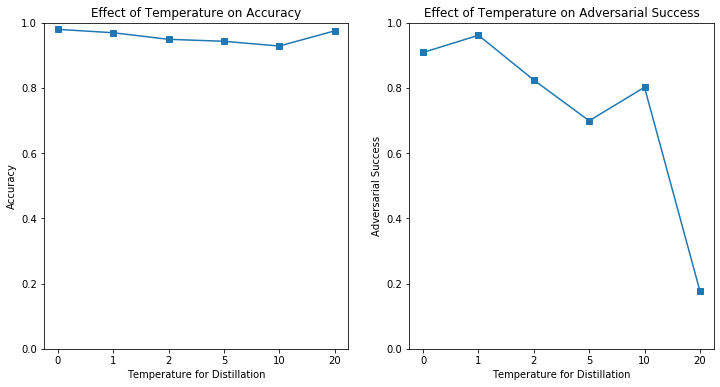

In [40]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].plot(range(6), mnist_accs, marker="s")
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('Temperature for Distillation')
ax[0].set_ylabel("Accuracy")
ax[0].set_xticks(range(6))
ax[0].set_xticklabels([0, 1, 2, 5, 10, 20])
ax[0].set_title("Effect of Temperature on Accuracy")

ax[1].plot(range(6), adv_successes, marker="s")
ax[1].set_ylim([0, 1])
ax[1].set_xlabel('Temperature for Distillation')
ax[1].set_ylabel("Adversarial Success")
ax[1].set_xticks(range(6))
ax[1].set_xticklabels([0, 1, 2, 5, 10, 20])
ax[1].set_title("Effect of Temperature on Adversarial Success")

pass

The above plots show that as temperature T is increased,
1. The accuracy is insignificantly reduced, however,
2. the trained model is significantly more robust against adversarial attacks (i.e. low adversarial success).

### Evaluate Defense Mechanism (Pt. 2)

In [10]:
epsilons = [.01, .05, .1, .15, .2, .25, .3]

naive_model = CNNModel().to(device)
naive_model.load_state_dict(torch.load('./victim-model.pth'))
naive_model.eval()

defensive_model = CNNModel().to(device)
defensive_model.load_state_dict(torch.load('./defensive_model_t20.pth')) # our best performing model
defensive_model.eval()

criterion = torch.nn.CrossEntropyLoss().to(device)

naive_rate = []
defensive_rate = []
for e in epsilons:
    print("Testing Epsilon = {}".format(e))
    a = test_model_adversarial(naive_model, mnist_test_data_loader, criterion, device, epsilon=e)
    b = test_model_adversarial(defensive_model, mnist_test_data_loader, criterion, device, epsilon=e)
    
    print("\tNaive Model Adversarial Success: {}".format(a))
    print("\tDefensive Model Adversarial Success: {}".format(b))
    
    naive_rate.append(a)
    defensive_rate.append(b)

  0%|          | 16/10000 [00:00<01:02, 159.47it/s]

Testing Epsilon = 0.01


  0%|          | 20/10000 [00:00<00:52, 191.56it/s]

	Naive Model Adversarial Success: 0.009597712885440065
	Defensive Model Adversarial Success: 0.008207653637016518
Testing Epsilon = 0.05


  0%|          | 15/10000 [00:00<01:08, 146.02it/s]

	Naive Model Adversarial Success: 0.061670410455380846
	Defensive Model Adversarial Success: 0.04493690366266544
Testing Epsilon = 0.1


  0%|          | 19/10000 [00:00<00:53, 186.77it/s]

	Naive Model Adversarial Success: 0.18991219113743107
	Defensive Model Adversarial Success: 0.12301220888478506
Testing Epsilon = 0.15


  0%|          | 20/10000 [00:00<00:51, 194.64it/s]

	Naive Model Adversarial Success: 0.40034715131713294
	Defensive Model Adversarial Success: 0.15963886323997128
Testing Epsilon = 0.2


  0%|          | 22/10000 [00:00<00:46, 215.02it/s]

	Naive Model Adversarial Success: 0.6161935879109659
	Defensive Model Adversarial Success: 0.1712321740022571
Testing Epsilon = 0.25


  0%|          | 20/10000 [00:00<00:51, 195.34it/s]

	Naive Model Adversarial Success: 0.8026342658770675
	Defensive Model Adversarial Success: 0.1759515748435416
Testing Epsilon = 0.3


100%|██████████| 10000/10000 [00:54<00:00, 184.61it/s]

	Naive Model Adversarial Success: 0.9087196242597508
	Defensive Model Adversarial Success: 0.17820867959372114


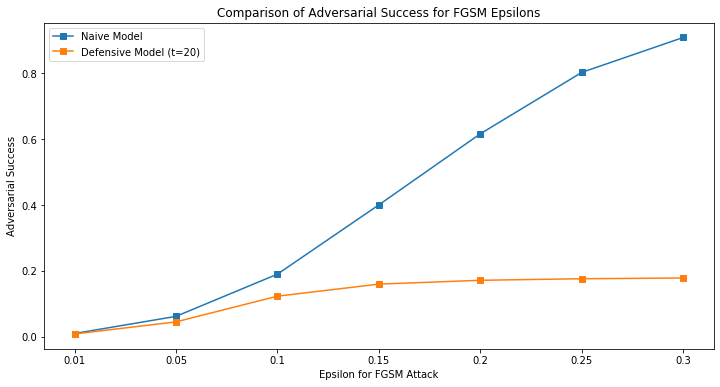

In [16]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(range(len(epsilons)), naive_rate, label='Naive Model', marker='s')
ax.plot(range(len(epsilons)), defensive_rate, label='Defensive Model (t=20)', marker='s')
ax.set_title("Comparison of Adversarial Success for FGSM Epsilons")
ax.set_ylabel("Adversarial Success")
ax.set_xlabel("Epsilon for FGSM Attack")
ax.set_xticks(range(len(epsilons)))
ax.set_xticklabels(epsilons)
ax.legend()

The above plot shows the effect of epsilon of FGSM attack (i.e. roughly put: the power/flexibility given to adversary) on adversarial success of naive and defensive model.

1. **Naive Model:** It is not able to detect adversarial perturbations to image, especially as epsilon increases.
2. **Defensive Model:** On the other hand, defensive model is still relatively very robust against adversarial examples, even when adversarial perturbations are high (i.e. when epsilon is high such as 0.3).

### 2.2: Conclusions (15 Points)
Please interpret the results of your defense here. 

* **Our Method (and why does it work):** We used Distillation technique as presented in [1] to make our classifier more robust against FGSM. The idea of the method is to use softened probabilities instead of hard labels. This makes the classifier's loss landscape relatively "flat." Essentially, the effect is that the gradient information atteneuates due to which gradient based attacks (including FGSM) do not work well.

* **On Robustness of Distillation Technique:** The defensive distillation model, as compared to typical classifier, is relatively much more robust against adversarial attacks, especially in large norm balls. As shown in the previous graph, as epsilon increases, even though typical classifier performs poorly against FGSM attack (i.e. high adversarial success of ~ 90%), the defensive classifer still is relatively much more robust against the attacks (i.e. low adversarial success of ~17%).

* **A Comment on Hyper-parameters** Following are the things we noticed regarding the hyper-parameters.
1. Higher temperature -> More training: Higher temperature essentially means more smoothening of labels. And we noticed in our experiments that more temperature requires more epochs to converge.
2. Higher temperature =/= more/less accuracy: Interestingly, higher temperature doesn't correlate with the final test accuracy of the MNIST dataset. This is in agreement in the results presented in the paper of the method we used.

Feel free to state any interesting finding you encountered during this project.